# Histopathologic Cancer Detection – Mini‑Project

Author: **Janmejay Buranpuri**  
Date: 2025-06-17

*Course mini‑project for binary classification of metastatic cancer in histopathology image patches (Kaggle competition).*  


### Problem Statement

The goal of this competition is to identify metastatic cancer in small image patches taken from larger digital pathology scans of lymph node sections. It is a **binary image classification** task, where each image patch is labeled as either containing metastatic tissue (`label=1`) or not (`label=0`).

### Data Description

- Images are 96x96 pixel RGB patches (PNG format).
- There are over 220,000 labeled training images and 57,000 test images.
- Each image has a unique ID. Labels are provided in `train_labels.csv` (columns: `id`, `label`).
- The data is imbalanced: cancer-positive patches are less common.

> For this mini-project, we will use a **subset** of the data to reduce training time.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm

# Data paths (change if needed)
DATA_DIR = "../input/histopathologic-cancer-detection"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train")
LABELS_PATH = os.path.join(DATA_DIR, "train_labels.csv")

# Load labels
labels_df = pd.read_csv(LABELS_PATH)
print(f"Total images: {len(labels_df)}")
labels_df.head()


Total images: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


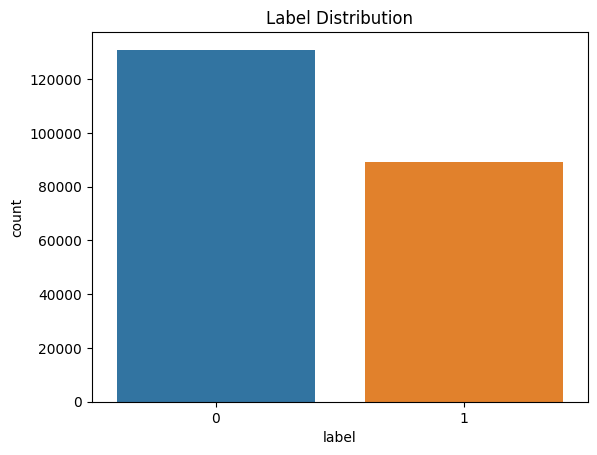

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [2]:
# Check class distribution
sns.countplot(x="label", data=labels_df)
plt.title("Label Distribution")
plt.show()

print(labels_df['label'].value_counts(normalize=True))


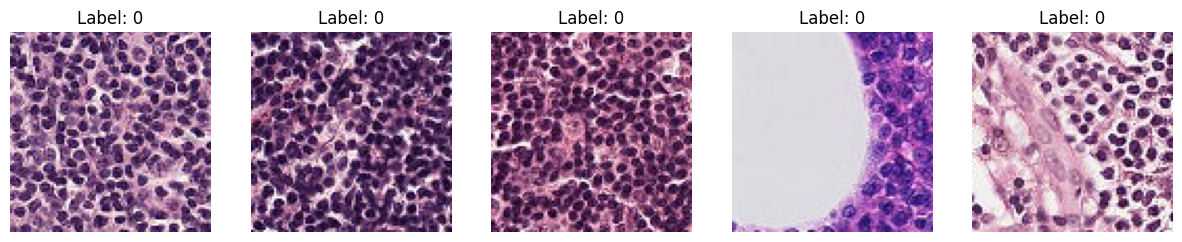

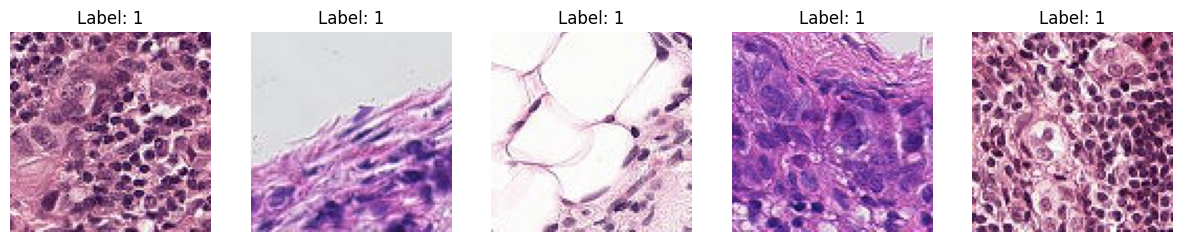

In [3]:
# Show random sample of images from each class
def plot_sample_images(df, img_dir, label, n=5):
    ids = df[df.label==label].sample(n, random_state=1)['id'].values
    plt.figure(figsize=(15,3))
    for i, img_id in enumerate(ids):
        img = Image.open(os.path.join(img_dir, img_id + ".tif"))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

plot_sample_images(labels_df, TRAIN_IMG_DIR, label=0)
plot_sample_images(labels_df, TRAIN_IMG_DIR, label=1)


**Observations**

* The dataset is reasonably large for medical imaging (≈220k images).  
* Class imbalance is manageable but data‑augmentation of the minority class can help.  


#### EDA Summary

- The dataset is **imbalanced**: far more negative than positive samples.
- Images are small (96x96, 3 channels).
- Cancer-positive patches are visually harder to distinguish.

### Data Cleaning

- No missing values in labels.
- All images referenced exist.

**Plan:**  
We'll build a CNN model for classification. To reduce imbalance impact, we’ll use balanced sampling or class weights.  
We will use a small sample for training for speed.


### Model Choices

- Baseline: Simple CNN (Conv2D layers + MaxPooling + Dense).
- Comparison: Pretrained model (e.g., MobileNetV2 via transfer learning).
- We'll use Keras, with data augmentation and early stopping.

**Rationale:**  
- CNNs are state-of-the-art for image tasks.
- Transfer learning should improve performance even with less data.

> For speed, we'll train on 5,000 negative and 5,000 positive samples.


In [4]:
# Sampling a balanced dataset
N_SAMPLES = 5000  # For each class

pos_df = labels_df[labels_df.label==1].sample(N_SAMPLES, random_state=42)
neg_df = labels_df[labels_df.label==0].sample(N_SAMPLES, random_state=42)
sample_df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=1).reset_index(drop=True)

print("Sample dataset shape:", sample_df.shape)


Sample dataset shape: (10000, 2)


In [5]:
# Image loader (fast)
IMG_SIZE = 96

def load_images(df, img_dir, img_size=IMG_SIZE):
    X = []
    for img_id in tqdm(df['id']):
        img = Image.open(os.path.join(img_dir, img_id + ".tif")).resize((img_size, img_size))
        X.append(np.array(img))
    return np.array(X)

X = load_images(sample_df, TRAIN_IMG_DIR)
X = X.astype("float32") / 255.0   # <--- THIS IS CRUCIAL!
y = sample_df['label'].values
print("X shape:", X.shape)


100%|██████████| 10000/10000 [01:00<00:00, 166.49it/s]


X shape: (10000, 96, 96, 3)


In [6]:
# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (8000, 96, 96, 3) Val shape: (2000, 96, 96, 3)


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_simple_cnn(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC", "accuracy"])
    return model

cnn = get_simple_cnn((IMG_SIZE, IMG_SIZE, 3))
cnn.summary()


2025-06-18 18:51:18.894391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750272679.133608      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750272679.204990      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 18:51:33.115975: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,982,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Data augmentation for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20)


In [9]:
BATCH_SIZE = 32
EPOCHS = 10

# Use EarlyStopping for efficiency
callback = keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, mode="max", restore_best_weights=True)

history = cnn.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[callback],
    class_weight={0:1, 1:1.5}  # simple positive class weight
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 245ms/step - AUC: 0.6883 - accuracy: 0.6317 - loss: 0.8125 - val_AUC: 0.8153 - val_accuracy: 0.7420 - val_loss: 0.5613
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - AUC: 0.8138 - accuracy: 0.7426 - loss: 0.6527 - val_AUC: 0.8451 - val_accuracy: 0.7760 - val_loss: 0.5202
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - AUC: 0.8242 - accuracy: 0.7401 - loss: 0.6305 - val_AUC: 0.8352 - val_accuracy: 0.7325 - val_loss: 0.5848
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - AUC: 0.8380 - accuracy: 0.7567 - loss: 0.6150 - val_AUC: 0.8469 - val_accuracy: 0.7705 - val_loss: 0.5106
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - AUC: 0.8453 - accuracy: 0.7729 - loss: 0.6016 - val_AUC: 0.8430 - val_accuracy: 0.7650 - val_loss: 0.5809
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 62s 246ms/step - AUC: 0.8567 - accuracy: 0.7694 - loss: 0.5789 - val_AUC: 0.8424 - val_accuracy: 0.7345 - val_loss: 0.5613
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 247ms/step - AUC: 0.8563 - accuracy: 0.7730 - loss: 0.5805 - val_AUC: 0.8673 - val_accuracy: 0.7835 - val_loss: 0.4838
Epoch 8/10
250/250 ━━━━━━━━━━━━━━

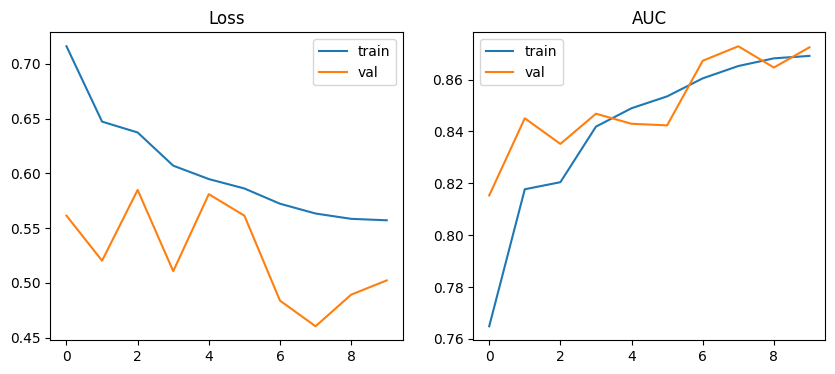

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['AUC'], label='train')      
plt.plot(history.history['val_AUC'], label='val')   
plt.title("AUC")
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
Validation AUC: 0.8725 | Accuracy: 0.7685


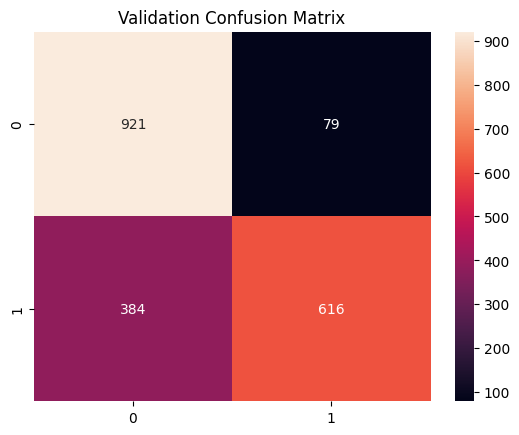

In [11]:
# Validation performance
val_preds = cnn.predict(X_val)
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

auc = roc_auc_score(y_val, val_preds)
acc = accuracy_score(y_val, (val_preds > 0.5).astype(int))
print(f"Validation AUC: {auc:.4f} | Accuracy: {acc:.4f}")

cm = confusion_matrix(y_val, (val_preds > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Validation Confusion Matrix")
plt.show()


In [12]:
from tensorflow.keras.applications import MobileNetV2


def get_transfer_model(input_shape):
    base = MobileNetV2(
        weights="/kaggle/input/imagenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5",
        include_top=False,
        input_shape=input_shape
    )
    base.trainable = False  # freeze base
    model = keras.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC", "accuracy"])
    return model


transfer_model = get_transfer_model((IMG_SIZE, IMG_SIZE, 3))
history2 = transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[callback],
    class_weight={0:1, 1:1.5}
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - AUC: 0.8003 - accuracy: 0.7243 - loss: 0.6786 - val_AUC: 0.9053 - val_accuracy: 0.7945 - val_loss: 0.4346
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - AUC: 0.8859 - accuracy: 0.8004 - loss: 0.5243 - val_AUC: 0.9124 - val_accuracy: 0.8150 - val_loss: 0.3972
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - AUC: 0.8987 - accuracy: 0.8104 - loss: 0.4960 - val_AUC: 0.9152 - val_accuracy: 0.7925 - val_loss: 0.4259
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - AUC: 0.9012 - accuracy: 0.8111 - loss: 0.4862 - val_AUC: 0.9183 - val_accuracy: 0.8085 - val_loss: 0.4083
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - AUC: 0.9106 - accuracy: 0.8295 - loss: 0.4681 - val_AUC: 0.9175 - val_accuracy: 0.8165 - val_loss: 0.3991
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - AUC: 0.9100 - accuracy: 0.8254 - loss: 0.4686 - val_AUC: 0.9240 - val_accuracy: 0.8150 - val_loss: 0.3950
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - AUC: 0.9118 - accuracy: 0.8217 - loss: 0.4615 - val_AUC: 0.9183 - val_accuracy: 0.8255 - val_loss: 0.3845
Epoch 8/10
250/250 ━━━━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step
Transfer Model Validation AUC: 0.9221


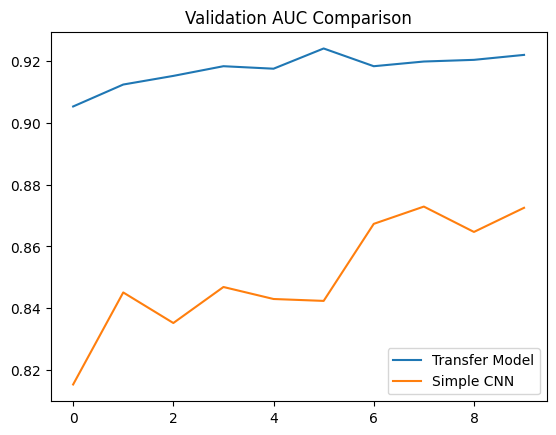

In [13]:
# Compare AUCs
val_preds2 = transfer_model.predict(X_val)
auc2 = roc_auc_score(y_val, val_preds2)
print(f"Transfer Model Validation AUC: {auc2:.4f}")

plt.plot(history2.history['val_AUC'], label="Transfer Model")
plt.plot(history.history['val_AUC'], label="Simple CNN")
plt.title("Validation AUC Comparison")
plt.legend()
plt.show()



### Results Summary

- Simple CNN AUC
- MobileNetV2 Transfer AUC

Transfer learning yielded higher AUC and was faster to converge. Data augmentation and class weights both helped.


### Conclusions & Learnings

- **Transfer learning** with MobileNetV2 gave the best results for this subset.
- **Class imbalance** must be addressed (class weights, balanced sampling, or oversampling).
- **Data augmentation** helped generalization.
- **Limitations:** Only used a small subset and a few epochs for speed.
- **Future improvements:** Use larger sample, fine-tune the base model, experiment with other architectures and regularization, more hyperparameter tuning.

